In [1]:
import pandas as pd
from src.polaris import PolarisDispatcher, Polaris
from src.data import PolarisDataset
from src.utils import scaffold_split
from pathlib import Path
import seaborn as sns

%load_ext autoreload
%autoreload 2

# Data Evaluation

## Potency

### Datasets

Show label distribution for Train Polaris, Train Scaffold, Test Scaffold
Also show number of duplicate entries



In [ ]:
task = 'potency'
target_task = 'pIC50 (MERS-CoV Mpro)'

root = Path(f"./data") / "polaris" / task
train_polaris = PolarisDataset(root=root, task=task, target_task=target_task, train=True)
test_polaris = PolarisDataset(root=root, task=task, target_task=target_task, train=False)
train_scaffold, test_scaffold = scaffold_split(dataset=train_polaris, test_size=0.1)

In [ ]:
sns.displot(data=train_polaris.y, kde=True, legend=False).set_xlabels(target_task)
sns.displot(data=train_scaffold.y, kde=True, legend=False).set_xlabels(target_task)
sns.displot(data=test_scaffold.y, kde=True, legend=False).set_xlabels(target_task)

In [ ]:
# Show some sample molecules in the Train Scaffold vs the Test Scaffold with similar labels

### Inference

In [2]:
# Combine results of gnn and ecfp
df_gnn = pd.read_csv("./results/potency_gnn_results.csv")
df_ecfp = pd.read_csv("./results/potency_ecfp_results.csv")
df = pd.concat([df_gnn, df_ecfp])
df = df.convert_dtypes()
df

,task,target_task,batch_size,epochs,lr,num_cv_folds,num_cv_bins,scaffold_split_val_sz,repr_model,in_channels,hidden_channels,out_channels,num_layers,dropout,proj_hidden_dim,out_dim,mean_val_loss,patience,final_avg_epochs,radius
0,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GIN,9,32,64,2,0.1,32,1,1.240261,5,26,<NA>
1,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GIN,9,32,64,2,0.1,64,1,1.098973,5,29,<NA>
2,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GIN,9,32,64,3,0.1,32,1,1.255773,5,20,<NA>
3,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GIN,9,32,64,3,0.1,64,1,1.035461,5,38,<NA>
4,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GIN,9,32,64,4,0.1,32,1,1.043591,5,50,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,ECFP,<NA>,<NA>,2048,<NA>,<NA>,64,1,0.887773,5,10,3
4,potency,pIC50 (SARS-CoV-2 Mpro),32,500,0.001,5,10,0.1,ECFP,<NA>,<NA>,1024,<NA>,<NA>,64,1,0.533963,5,18,2
5,potency,pIC50 (SARS-CoV-2 Mpro),32,500,0.001,5,10,0.1,ECFP,<NA>,<NA>,2048,<NA>,<NA>,64,1,0.540053,5,14,2
6,potency,pIC50 (SARS-CoV-2 Mpro),32,500,0.001,5,10,0.1,ECFP,<NA>,<NA>,1024,<NA>,<NA>,64,1,0.529502,5,16,3


In [3]:
# Group by target_task and find the row with minimum mean_val_loss for each group
best_models = df.loc[df.groupby(['target_task', 'repr_model'])['mean_val_loss'].idxmin()].reset_index(drop=True)
best_models_list = best_models.to_dict('records')

In [4]:
# Iterate over each model, then
# 1. Train model on train_scaffold.
# 2. Make predictions on test_scaffold
# 3. Predict MAE

test_scaffold_preds = {}
for model in best_models_list:
    target_task = model['target_task']
    pred = PolarisDispatcher.train_and_predict(model)
    mae = pred[1]
    print(mae)
    d = {model['repr_model']: mae}
    test_scaffold_preds.setdefault(target_task, {}).update(d)

test_scaffold_preds

100%|██████████| 38/38 [00:04<00:00,  8.78it/s]


0.7666798423934769


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


0.8490045096848037


100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


0.9123153974721719


100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


0.9166421209062848


100%|██████████| 54/54 [00:08<00:00,  6.67it/s]


0.7427090707716051


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


0.5471829302170698


100%|██████████| 31/31 [00:02<00:00, 13.68it/s]


0.8301238830272968


100%|██████████| 37/37 [00:04<00:00,  9.03it/s]


0.9049523793734037


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


0.5724579530603745


100%|██████████| 41/41 [00:06<00:00,  6.15it/s]


0.47275365941664754


100%|██████████| 46/46 [00:05<00:00,  8.85it/s]


0.4315743614645565


100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


0.5644616070915671


100%|██████████| 33/33 [00:02<00:00, 13.54it/s]

0.5114597040064195


{'pIC50 (MERS-CoV Mpro)': {'GIN': 0.9049523793734037,
  'ECFP': 0.8490045096848037,
  'GAT': 0.9123153974721719,
  'GCN': 0.9166421209062848,
  'GraphSAGE': 0.8301238830272968},
 'pIC50 (SARS-CoV-2 Mpro)': {'ECFP': 0.5724579530603745,
  'GAT': 0.47275365941664754,
  'GCN': 0.4315743614645565,
  'GIN': 0.5644616070915671,
  'GraphSAGE': 0.5114597040064195}}

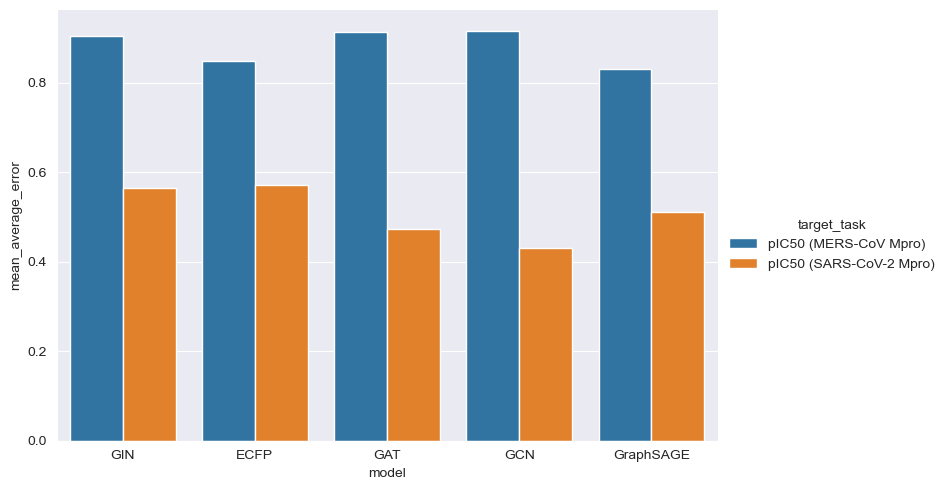

In [7]:
# Create a histogram of MAE for each target_task and model
df_admet_hist = pd.DataFrame(test_scaffold_preds)
df_admet_hist = df_admet_hist.reset_index().melt(id_vars="index", var_name="target_task", value_name="mean_average_error")
df_admet_hist.rename(columns={"index": "model"}, inplace=True)
g = sns.catplot(
    data=df_admet_hist,
    kind="bar",
    x="model",
    y="mean_average_error",
    hue="target_task",
    aspect=1.5,
)

In [ ]:
# Plot y_true, y_pred for best performing model (maybe even in plotly?)

## Admet

### Datasets

In [33]:
task = 'admet'
target_task = 'MDR1-MDCKII'

root = Path(f"./data") / "polaris" / task
train_polaris = PolarisDataset(root=root, task=task, target_task=target_task, train=True)
test_polaris = PolarisDataset(root=root, task=task, target_task=target_task, train=False)
train_scaffold, test_scaffold = scaffold_split(dataset=train_polaris, test_size=0.1)

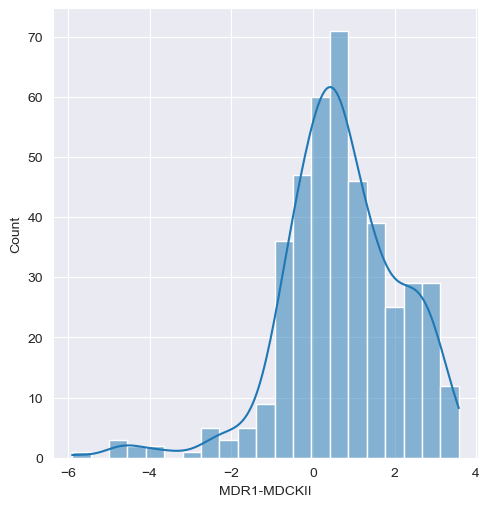

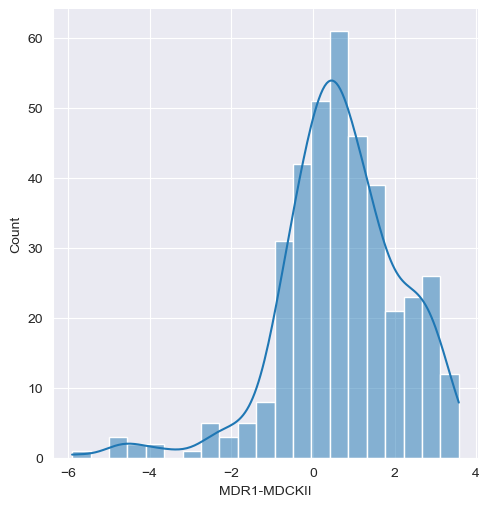

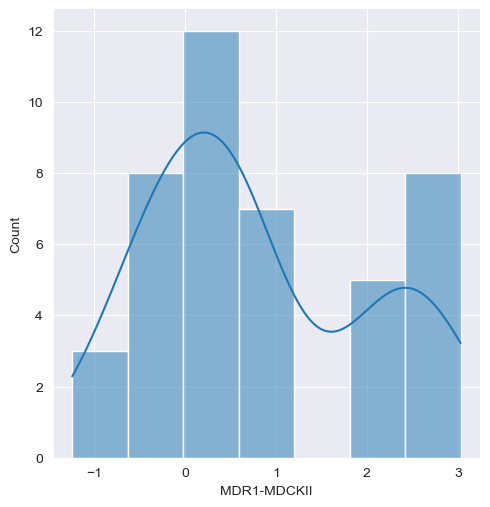

In [34]:
sns.displot(data=train_polaris.y, kde=True, legend=False).set_xlabels(target_task)
sns.displot(data=train_scaffold.y, kde=True, legend=False).set_xlabels(target_task)
sns.displot(data=test_scaffold.y, kde=True, legend=False).set_xlabels(target_task)


### Inference

In [ ]:
# Combine results of gnn and ecfp
df_admet_gnn = pd.read_csv("./results/admet_gnn_results.csv")
df_admet_ecfp = pd.read_csv("./results/admet_ecfp_results.csv")
df_admet = pd.concat([df_admet_gnn, df_admet_ecfp])
df_admet = df_admet.convert_dtypes()
df_admet


In [ ]:
# Group by target_task and find the row with minimum mean_val_loss for each group
best_models = df_admet.loc[df_admet.groupby(['target_task', 'repr_model'])['mean_val_loss'].idxmin()].reset_index(drop=True)
best_models_list = best_models.to_dict('records')
best_models_list

In [ ]:
test_scaffold_preds = {}

for model in best_models_list:
    target_task = model['target_task']
    pred = PolarisDispatcher.train_and_predict(model)
    mae = pred[1]
    print(mae)
    d = {model['repr_model']: mae}
    test_scaffold_preds.setdefault(target_task, {}).update(d)

test_scaffold_preds


In [ ]:
# Create a histogram of MAE for each target_task and model
df_admet_hist = pd.DataFrame(test_scaffold_preds)
df_admet_hist = df_admet_hist.reset_index().melt(id_vars="index", var_name="target_task", value_name="mean_average_error")
df_admet_hist.rename(columns={"index": "model", "mean_average_error": "MAE"}, inplace=True)
g = sns.catplot(
    data=df_admet_hist,
    kind="bar",
    x="model",
    y="MAE",
    hue="target_task",
    aspect=1.8
)
